In [32]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import ast
import json
from collections import defaultdict
from matplotlib import pyplot as plt
from math import cos, sin
import cv2
import numpy as np
import pandas as pd
import neuroglancer
from tqdm import tqdm
from skimage import io
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
HOME = os.path.expanduser("~")

In [2]:
def reverse_transform_create_alignment(points, transform):
    c = np.hstack((points, np.ones((points.shape[0], 1))))
    b = transform.copy()[:, 0:2] # Reverse rotation matrix by doing R^-1 = R^T
    b[2:, 0:2] = -transform[0:2, 2] # Reverse translation matrix by doing -T
    a = np.matmul(c, b)
    return a

def parse_elastix_parameter_file(filepath):
    """
    Parse elastix parameter result file.
    """
    def parameter_elastix_parameter_file_to_dict(filename):
        d = {}
        with open(filename, 'r') as f:
            for line in f.readlines():
                if line.startswith('('):
                    tokens = line[1:-2].split(' ')
                    key = tokens[0]
                    if len(tokens) > 2:
                        value = []
                        for v in tokens[1:]:
                            try:
                                value.append(float(v))
                            except ValueError:
                                value.append(v)
                    else:
                        v = tokens[1]
                        try:
                            value = (float(v))
                        except ValueError:
                            value = v
                    d[key] = value
            return d

    d = parameter_elastix_parameter_file_to_dict(filepath)

    # For alignment composition script
    rot_rad, x_mm, y_mm = d['TransformParameters']
    center = np.array(d['CenterOfRotationPoint']) / np.array(d['Spacing'])
    # center[1] = d['Size'][1] - center[1]

    xshift = x_mm / d['Spacing'][0]
    yshift = y_mm / d['Spacing'][1]

    R = np.array([[np.cos(rot_rad), -np.sin(rot_rad)],
                  [np.sin(rot_rad), np.cos(rot_rad)]])
    shift = center + (xshift, yshift) - np.dot(R, center)
    T = np.vstack([np.column_stack([R, shift]), [0, 0, 1]])
    return T


def load_consecutive_section_transform(animal, moving_fn, fixed_fn):
    """
    Load pairwise transform.

    Returns:
        (3,3)-array.
    """
    
    elastix_output_dir = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/elastix'

    param_fp = os.path.join(elastix_output_dir, moving_fn + '_to_' + fixed_fn, 'TransformParameters.0.txt')
    #sys.stderr.write('Load elastix-computed transform: %s\n' % param_fp)
    if not os.path.exists(param_fp):
        raise Exception('Transform file does not exist: %s to %s, %s' % (moving_fn, fixed_fn, param_fp))
    transformation_to_previous_sec = parse_elastix_parameter_file(param_fp)

    return transformation_to_previous_sec

def parse_elastix(animal):
    """
    After the elastix job is done, this goes into each subdirectory and parses the Transformation.0.txt file
    Args:
        animal: the animal
    Returns: a dictionary of key=filename, value = coordinates
    """
    #fileLocationManager = FileLocationManager(animal)
    #DIR = fileLocationManager.prep
    DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
    INPUT = os.path.join(DIR, 'CH1', 'thumbnail_cleaned')

    image_name_list = sorted(os.listdir(INPUT))
    anchor_idx = len(image_name_list) // 2
    # anchor_idx = len(image_name_list) - 1
    transformation_to_previous_sec = {}

    for i in range(1, len(image_name_list)):
        fixed_fn = os.path.splitext(image_name_list[i - 1])[0]
        moving_fn = os.path.splitext(image_name_list[i])[0]
        transformation_to_previous_sec[i] = load_consecutive_section_transform(animal, moving_fn, fixed_fn)

    transformation_to_anchor_sec = {}
    # Converts every transformation
    for moving_idx in range(len(image_name_list)):
        if moving_idx == anchor_idx:
            transformation_to_anchor_sec[image_name_list[moving_idx]] = np.eye(3)
        elif moving_idx < anchor_idx:
            T_composed = np.eye(3)
            for i in range(anchor_idx, moving_idx, -1):
                T_composed = np.dot(np.linalg.inv(transformation_to_previous_sec[i]), T_composed)
            transformation_to_anchor_sec[image_name_list[moving_idx]] = T_composed
        else:
            T_composed = np.eye(3)
            for i in range(anchor_idx + 1, moving_idx + 1):
                T_composed = np.dot(transformation_to_previous_sec[i], T_composed)
            transformation_to_anchor_sec[image_name_list[moving_idx]] = T_composed

    return transformation_to_anchor_sec

def create_warp_transforms(transforms, downsample_factor=32):
    def convert_2d_transform_forms(arr):
        return np.vstack([arr, [0, 0, 1]])
    
    transforms_scale_factor = 32 / downsample_factor 
    tf_mat_mult_factor = np.array([[1, 1, transforms_scale_factor], [1, 1, transforms_scale_factor]])
    transforms_to_anchor = {}
    for img_name, tf in transforms.items():
        transforms_to_anchor[img_name] = convert_2d_transform_forms(np.reshape(tf, (3, 3))[:2] * tf_mat_mult_factor) 

    return transforms_to_anchor


In [43]:
animal = 'DK55'
downsample_factor = 32
section = 224
PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
filename = str(section).zfill(3) + '.tif'
filepath = os.path.join(PATH, 'CH3/full', filename)
img = io.imread(filepath)
CSV_DIR_PATH = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/{animal}'
resolution = 0.325
#width = 34000
#height = 60000
aligned_shape = np.array((60000, 34000))
downsampled_aligned_shape = np.round(aligned_shape / downsample_factor).astype(int)
scales = np.array([resolution * downsample_factor, resolution * downsample_factor, 20]) * 1000

In [4]:
dk_csvfile = 'dklabs.premotor.csv'
dk_csvpath = os.path.join(CSV_DIR_PATH, dk_csvfile)
dk_df = pd.read_csv(dk_csvpath, usecols=['Layer', 'x', 'y', 'section'])
dk_df = dk_df.loc[(dk_df['Layer'] == 'Premotor') & (dk_df['section'] == section)]
dk_df = dk_df.round(0)
dk_df = dk_df.astype({'x': 'int32', 'y':'int32'})
dk_df = dk_df.sort_values(by=['x', 'y'])

14899 27819


In [152]:
PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
filename = str(section).zfill(3) + '.tif'
filepath = os.path.join(PATH, 'CH3/full', filename)
input_image = Image.open(filepath)
rotated_height = input_image.width
cshl_csvfile = 'cshl.premotor.csv'
cshl_csvpath = os.path.join(CSV_DIR_PATH, cshl_csvfile)
cshl_df = pd.read_csv(cshl_csvpath, names=['section','x','y'])
cshl_df = cshl_df.loc[(cshl_df['section'] == section)]
# x = y
# y = height - x
cshl_df['xp'] = cshl_df['y']
cshl_df['yp'] = rotated_height - cshl_df['x']

In [153]:
cshl_df.head()

,section,x,y,xp,yp
204,224,13062,9888,9888,16736
205,224,12710,10560,10560,17088
206,224,12550,39232,39232,17248
207,224,12198,39072,39072,17600
208,224,12326,39520,39520,17472


## Get the annotation points

In [ ]:
structures = ['premotor']
section_structure_vertices = defaultdict(dict)
vertices = []
for index, row in cshl_df.iterrows():
    SN = section
    ST = 'premotor'
    x = row['x']
    y = row['y']
    vertices.append([x,y])
    #section_structure_vertices[SN][ST] = row['vertices']
section_structure_vertices[section]['premotor'] = vertices

In [ ]:
#section_structure_vertices

In [ ]:
print(section, downsample_factor, downsampled_aligned_shape)

## Reproduce create_clean transform

In [ ]:
IMAGE_PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH3'
section_offset = {}
filename = str(section).zfill(3) + '.tif'
aligned_path = os.path.join(IMAGE_PATH, 'thumbnail_aligned', filename)
unaligned_path = os.path.join(IMAGE_PATH, 'thumbnail', filename)
aligned = io.imread(aligned_path)
unaligned = io.imread(unaligned_path)
aligned_shape = np.array(aligned.shape)
unaligned_shape = np.array(unaligned.shape)

#width, height = img.shape
#section_offset[section] = (downsampled_aligned_shape - downsampled_shape) // 2
section_offset[section] = (aligned_shape - unaligned_shape) // 2

In [ ]:
print(downsampled_aligned_shape)
print(section, downsample_factor, section_offset)
#section_offset[section] = [472,-339]

## Reproduce create_alignment transform

In [ ]:
transforms = parse_elastix(animal)
warp_transforms = create_warp_transforms(transforms, downsample_factor)
ordered_transforms = sorted(warp_transforms.items())

section_transform = {}
for filename, transform in ordered_transforms:
    section_num = int(filename.split('.')[0])
    transform = np.linalg.inv(transform)
    section_transform[section_num] = transform

## Alignment of annotation coordinates

In [ ]:
'''
(x', y') = (x * sx + y * ry + tx, x * rx + y * sy + ty)
'sx': T[0, 0], 'sy': T[1, 1], 'rx': T[1, 0], 'ry': T[0, 1], 'tx': T[0, 2], 'ty': T[1, 2]
'''
def transform_create_alignment(points, transform):
    a = np.hstack((points, np.ones((points.shape[0], 1))))
    b = transform.T[:, 0:2]
    c = np.matmul(a, b)
    return c

aligned_section_structure_polygons = defaultdict(dict)
for section in section_structure_vertices:
    for structure in section_structure_vertices[section]:
        points = np.array(section_structure_vertices[section][structure]) // downsample_factor
        points = points + section_offset[section] # create_clean offset
        points = transform_create_alignment(points, section_transform[section]) # create_alignment transform
        aligned_section_structure_polygons[section][structure] = [points]

In [ ]:
for k,v in aligned_section_structure_polygons.items():
    for k1,v1 in v.items():
        print(k,k1,len(v1[0]))
        points = v1[0]

df = pd.DataFrame(points, columns=['x','y'])
df = df.round(0)
df = df.astype({'x': 'int32', 'y':'int32'})
#df = df.sort_values(by=['x', 'y'])
df['section'] = section
#outfile = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/DK55/cshl2dk.{section}.csv'
#df.to_csv(outfile, index=False)
df[['x','y','section']].head(10)

To this point, aligned_section_structure_polygons variable contains the aligned polygon vertices for each structure in each section. 
From now on, we introduce how to draw these points to numpy array or neuroglancer

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
#'VCA', 'VCP', 'DC'
unpad = lambda x: x[:, :-1]

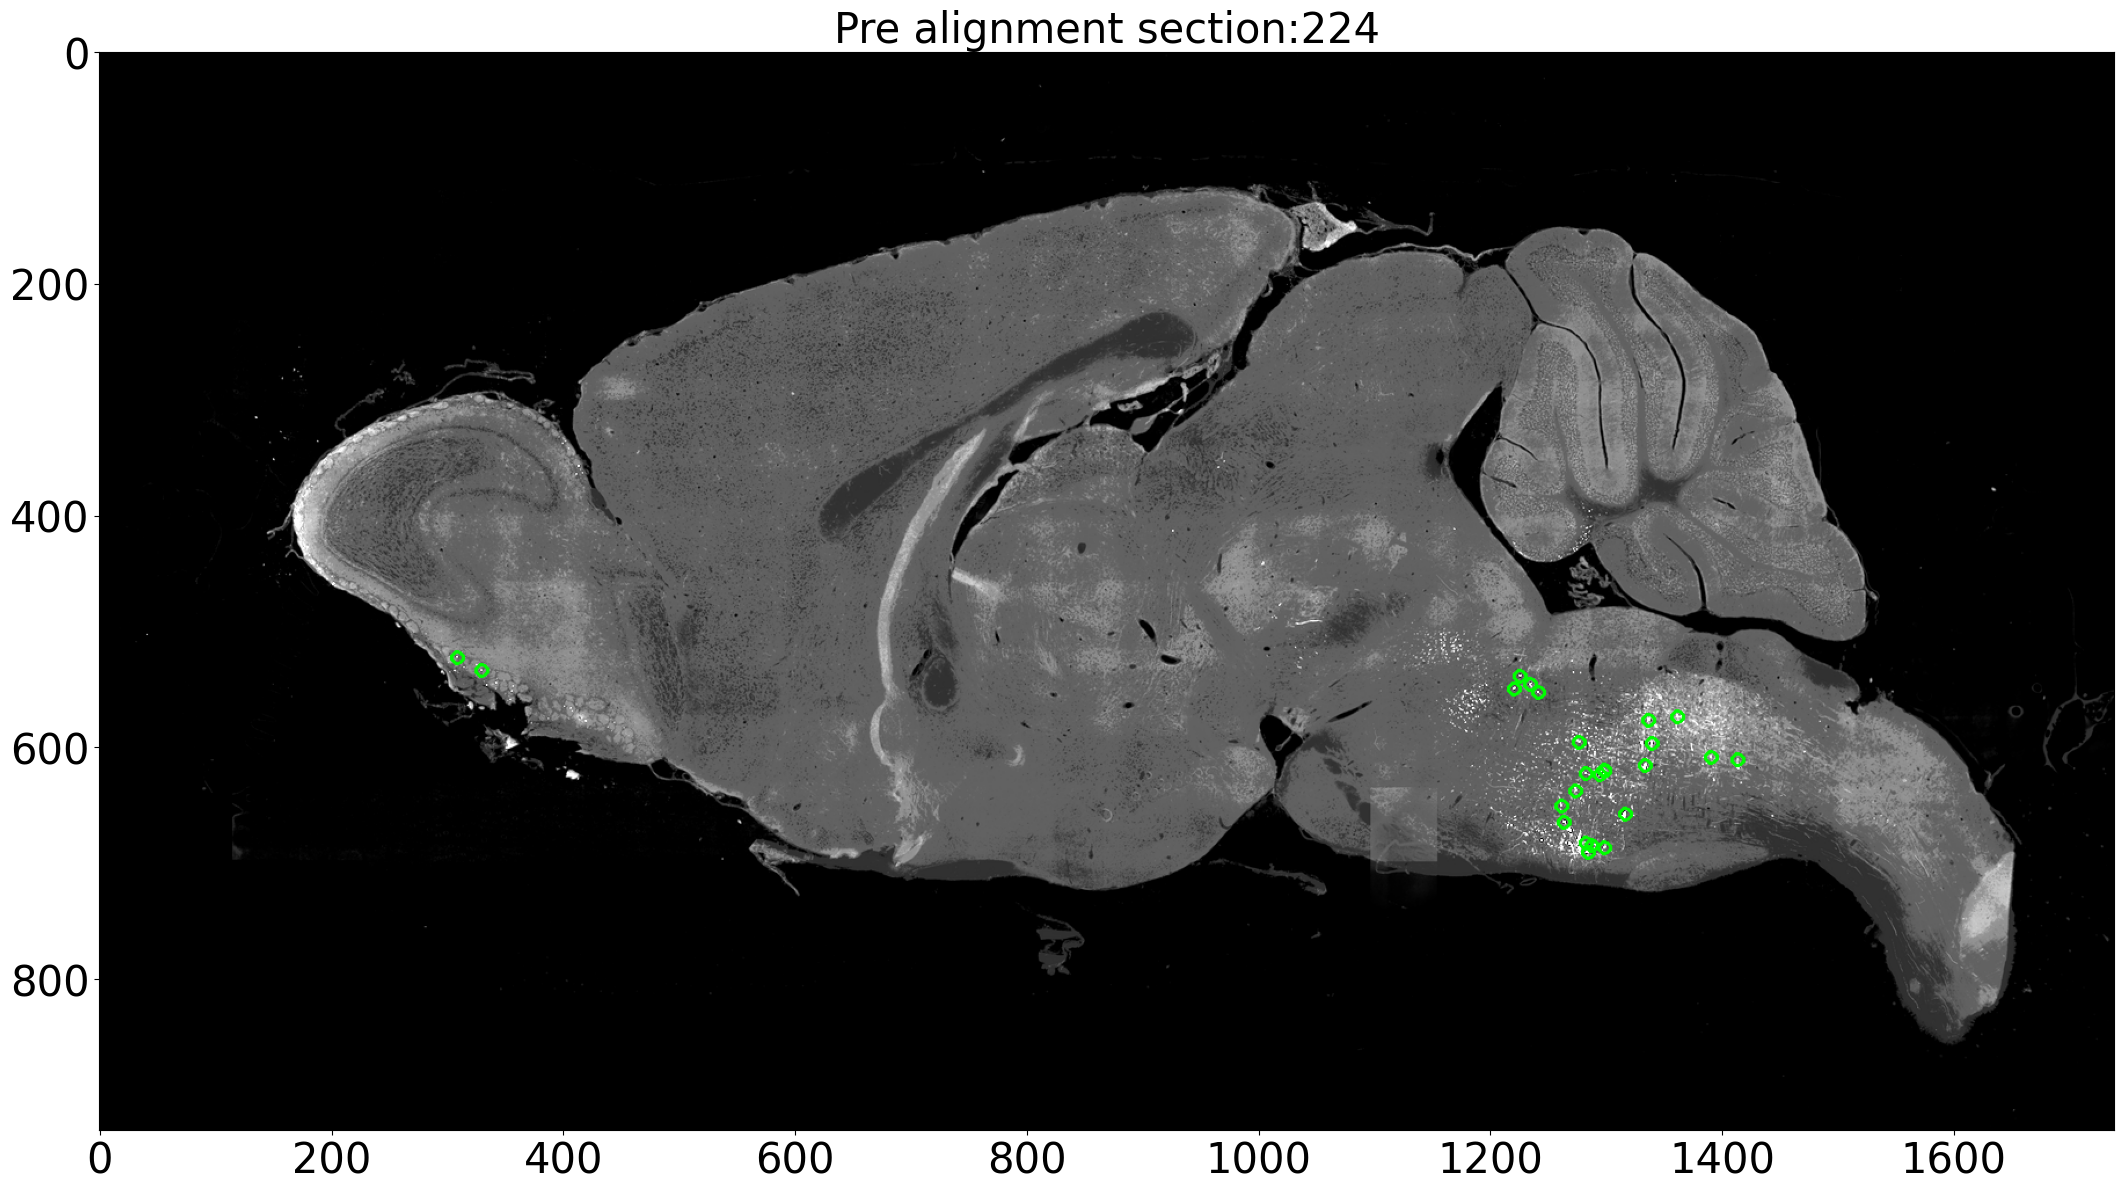

In [151]:
file_name = f'{str(section).zfill(3)}.tif'
PATH = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK55/preps/CH3'
outpath = os.path.join(PATH, '224.unaligned.out.tif')
filepath = os.path.join(PATH, '224.norm.tif')
img = cv2.imread(filepath)
radius = 5
color = (0,255,0)
for index, row in cshl_df.iterrows():
    x = row['x'] / 32
    y = row['y'] / 32
    xp = row['xp'] / 32
    yp = row['yp'] / 32
    #print(x,y, xp, yp)
    cv2.circle(img, (int(xp), int(yp)), radius, color, 2)

cv2.imwrite(outpath, img)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('Pre alignment section:{}'.format(section), fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()

shape (300, 100, 3)
original 30 250
rotated 90 50.0 30.0
(300, 100, 3) uint8


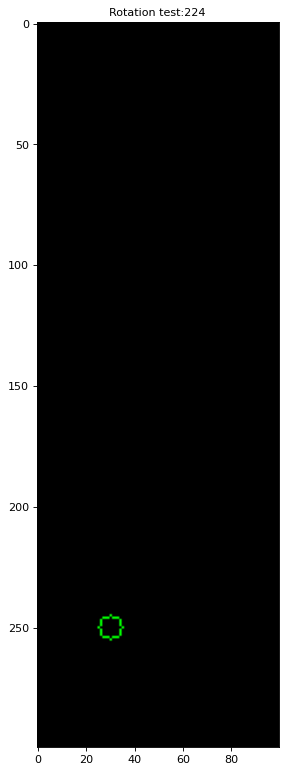

In [137]:
width = 100
height = 300
img = np.zeros((height, width, 3), np.uint8)
x = 30
y = 250
theta = 90
angle = np.pi / theta  # angle in radian
center_x = width / 2
center_y = height / 2
xp = (x - center_x) * cos(angle) - (y - center_y) * sin(angle) + center_x
yp = (x - center_x) * sin(angle) + (y - center_y) * cos(angle) + center_y

cartesianx = x - center_x
cartesiany = -y + center_y
# rotate 270  point A(x,y) becomes A'(y,-x).
cartesianxr = cartesiany
cartesianyr = -cartesianx
#Convert to Screen:
screenx = cartesianxr + center_y;
screeny = -cartesianyr + center_x;
print('shape', img.shape)
print('original', x, y)
print('rotated',theta, screenx, screeny)

print(img.shape, img.dtype)
cv2.circle(img, (int(x), int(y)), radius, (0,255,0), 1)
#cv2.circle(img, (int(screenx), int(screeny)), radius, (255,0,0), 1)

fig=plt.figure(figsize=(5,12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('Rotation test:{}'.format(section), fontsize=10)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.show()

In [ ]:
#162, 185, 210
file_name = f'{str(section).zfill(3)}.tif'
filepath = os.path.join(DOWN32, file_name)
img = cv2.imread(filepath)
section = int(file_name.split('.')[0])
color = (0,255,0)
radius = 10
for structure in section_structure_vertices[section]:
    pts = section_structure_vertices[section][structure]
    points = np.array(pts, dtype=np.int32)
    offset = section_offset[section]
    transform = section_transform[section]
    
    points = reverse_transform_create_alignment(points, section_transform[section]) # reverse create_alignment transform
    points = (points - section_offset[section]).astype(np.int32) # reverse create_clean offset
    
    
    cx, cy = np.mean(points, axis=0)
    cx = int(cx // 32)
    cy = int(cy // 32)
    #print(structure,section,'with centers',cx,cy, 'offset', offset, pts)
    #cv2.polylines(img, [points], isClosed=True, color=colors[structure], thickness=2)
    cv2.circle(img, (cx,cy), radius, color, thickness)
    #cv2.putText(img, structure, (int(cx),int(cy)), font,1, colors[structure], 1, cv2.LINE_AA)

fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('Pre alignment section:{}'.format(section), fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()

# Fill up a pandas dataframe with the corrected vertices and save it.

In [ ]:
data = []

files = sorted(os.listdir(DOWN32))
for file_name in files:
    section = int(file_name.split('.')[0])
    
    if section in section_structure_vertices:
        for structure in section_structure_vertices[section]:
            pts = section_structure_vertices[section][structure]
            points = np.array(pts, dtype=np.int32)
            points = reverse_transform_create_alignment(points, section_transform[section]) # reverse create_alignment transform
            points = points - section_offset[section] # reverse create_clean offset
            data.append([structure, section, points])
            
df = pd.DataFrame(data=data, columns=['structure', 'section', 'vertices'])
outpath = os.path.join(CSV_DIR_PATH, f'{animal}_sections.162.185.210.csv')
df.to_csv(outpath, index=False)
redone_vertices = defaultdict(dict)
for index,row in df.iterrows():
    section = row['section']
    structure = row['structure']
    points = row['vertices']
    redone_vertices[section][structure] = points

In [ ]:
sections = [162, 185, 210]

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
file_name = '210.tif'
filepath = os.path.join(DOWN32, file_name)
img = cv2.imread(filepath)
section = int(file_name.split('.')[0])

sl = []
for structure in section_structure_vertices[section]:
    pts = redone_vertices[section][structure]
    points = np.array(pts, dtype=np.int32)
    cx, cy = np.mean(points, axis=0)
    sl.append(structure)
    #print(structure,section,'with centers',cx,cy, 'offset', offset)
    cv2.polylines(img, [points], isClosed=True, color=colors[structure], thickness=2)
    cv2.putText(img, structure, (int(cx-5),int(cy-5)), font,
                1, colors[structure], 1, cv2.LINE_AA)

fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('MD589 at 1/32 size section:{}, structures {}'.format(section, sl), fontsize=20)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()
fig.savefig(f'/home/eddyod/Desktop/MD589.section{section}.jpg', bbox_inches='tight')